In [1]:
import numpy as np
import lmdb
import sys
sys.path.insert(0,'../python')
import caffe
import os
import cv2
from scipy import misc
from os.path import expanduser
home_dir = expanduser("~")
coco_root = home_dir+'/data/coco'
from pycocotools.coco import COCO
from pycocotools.mask import *
import skimage.io as io
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
annType = 'segm'
dataType='val2014'
annFile = '%s/annotations/instances_%s.json'%(coco_root,dataType)
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=7.89s)
creating index...
index created!


In [ ]:
cats = cocoGt.getCatIds()
k=1
catdict={}
lmdb_dir = '%s/preprocessed/lmdb/%s-lmdb'%(coco_root,dataType)

if not os.path.exists(lmdb_dir):
    os.makedirs(lmdb_dir)
    
for catid in cats:
    catdict[catid] = k
    k = k+1
    
imgIds = cocoGt.getImgIds()


map_size = 1099511627776 / 10
env = lmdb.open(lmdb_dir, map_size=map_size)
with env.begin(write=True) as txn:
    # txn is a Transaction object    
    for imgId in imgIds:
        img = cocoGt.loadImgs(imgId)[0]
        I = io.imread('%s/images/%s/%s'%(coco_root,dataType,img['file_name']))
        if I.ndim==2:
            I = np.expand_dims(I, axis=2)
            I = np.tile(I,(1,1,3))
        Cmap = np.zeros((81,I.shape[0],I.shape[1]))
        annIds = cocoGt.getAnnIds(imgIds=imgId)
        anns = cocoGt.loadAnns(annIds) 
        for ann in anns:
            segm = ann['segmentation']
            if type(segm) == dict:
                temp = [segm]
                segm = temp
            Rs = frPyObjects( segm, img['height'], img['width'] )
            masks = decode(Rs)
            masks = masks.max(axis=2)
            catid = ann['category_id']
            Cmap[catdict[catid]] = np.maximum(Cmap[catdict[catid]],masks)
        # Background map
        BGmap = np.ones(I.shape[0:2]) - Cmap.max(axis=0)
        Cmap[0] = BGmap
        # resize label map to 512*512
        Cmap = np.transpose(np.round(cv2.resize(np.transpose(Cmap,(1,2,0)),(512,512))).astype(np.uint8),(2,0,1))
        # Check whether the map is binary
        if not np.any(np.bitwise_or(Cmap==0,Cmap==1)):
            raise('Class map should be binary')
        # resize image to 512*512
        I = cv2.resize(I,(512,512))
        # change image to c*h*w
        I = np.transpose(I,(2,0,1))
        # chage image to BGR
        I = I[(2,1,0),:,:]
        # concatenate image and label map
        data = np.concatenate((I,Cmap),axis=0)
        datum = caffe.proto.caffe_pb2.Datum()
        datum.channels = data.shape[0]
        datum.height = data.shape[1]
        datum.width = data.shape[2]
        datum.data = data.tobytes()
        datum.label = 0
        str_id = '{:08}'.format(imgId)
        txn.put(str_id.encode('ascii'), datum.SerializeToString())

uint8 uint8
0


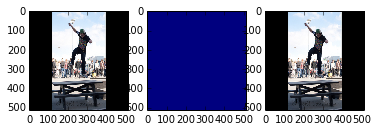

In [70]:
plt.subplot(1,3,1)
data = np.concatenate((I,Cmap),axis=0)
print data.dtype, I.dtype
img1 = data[0:3]
Cmap = data[3:]
label_person = Cmap[60]
img2 = I
print np.min(Cmap)
plt.imshow(np.transpose(img1[(2,1,0),:,:],(1,2,0)))
plt.subplot(132)
plt.imshow(label_person)
plt.subplot(1,3,3)
plt.imshow(np.transpose(img2[(2,1,0),:,:],(1,2,0)))

In [5]:
import scipy.io as sio
file = '003_014_I01049.mat'
data = sio.loadmat(os.path.join('../caltech_peds/caltech_small/images/', file))
I = data['I'] 
data = sio.loadmat(os.path.join('../caltech_peds/caltech_small/labels/', file))
P = data['P']
data = sio.loadmat(os.path.join('../caltech_peds/caltech_small/loc/', file))
L = data['L']
X = np.dstack((I[:,:,(2,1,0)],P,L))
X = np.transpose(X,(2,0,1)) 
caffe.set_mode_cpu()
net.blobs['data'].data[...]=X
res = net.forward()

(480, 640, 3) (480, 640, 3) (480, 640, 3)
255
255
0.0
0.0
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


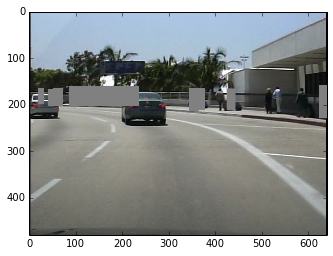

In [66]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
file = '003_014_I01049.mat'
data = sio.loadmat(os.path.join('../caltech_peds/caltech_small/images/', file))
I = data['I'] 
data = sio.loadmat(os.path.join('../caltech_peds/caltech_small/labels/', file))
P = data['P']
data = sio.loadmat(os.path.join('../caltech_peds/caltech_small/loc/', file))
L = data['L']
X = np.dstack((I[:,:,(2,1,0)],P,L))
X = np.transpose(X,(2,0,1)) 
caffe.set_mode_cpu()
net.blobs['data'].data[...]=X
res = net.forward()
Inet = res['img']
Pnet = res['ped']
Inet = np.squeeze(Inet)
Pnet = np.squeeze(Pnet)
Inet = np.transpose(Inet, (1,2,0))
Inet = Inet[:,:,(2,1,0)]
plt.imshow(I-Inet)
diff = I-Inet
plt.imshow(I)
print I.shape, Inet.shape, diff.shape
print np.max(I)
print np.max(I)
print np.min(diff)
print np.max(diff)
print diff[:,:,1]

In [103]:
import numpy as np
import lmdb
import sys
sys.path.insert(0,'./python')
import caffe
import os
from scipy import misc
# Let's pretend this is interesting data
# We need to prepare the database for the size. We'll set it 10 times
# greater than what we theoretically need. There is little drawback to
# setting this too big. If you still run into problem after raising
# this, you might want to try saving fewer entries in a single
# transaction.
map_size = 921600 * 865 * 30

env = lmdb.open('../fcn-lstm/data/ped/ped-lmdb-train', map_size=map_size)
with env.begin(write=True) as txn:
    # txn is a Transaction object    
    for root, dirs, files in os.walk("../caltech_peds/caltech_small/images/"):
        for file in files:
            if file.endswith(".mat") and not file.startswith("009"):
                datum = caffe.proto.caffe_pb2.Datum()
                data = sio.loadmat(os.path.join(root, file))
                I = data['I'] 
                meanvalue = np.array([104,117,123])
                I = I[:,:,(2,1,0)]
                I = I-meanvalue
                data = sio.loadmat(os.path.join('../caltech_peds/caltech_small/labels/', file))
                P = data['P']
                data = sio.loadmat(os.path.join('../caltech_peds/caltech_small/loc/', file))
                L = data['L']
                X = np.dstack((I,P,L))
                X = np.transpose(X,(2,0,1)) 
                datum.channels = X.shape[0]
                datum.height = X.shape[1]
                datum.width = X.shape[2]
                datum.data = X.tobytes()
                datum.label = 0
                str_id = file
                txn.put(str_id.encode('ascii'), datum.SerializeToString())
                
env = lmdb.open('../fcn-lstm/data/ped/ped-lmdb-val', map_size=map_size)
with env.begin(write=True) as txn:
    # txn is a Transaction object    
    for root, dirs, files in os.walk("../caltech_peds/caltech_small/images/"):
        for file in files:
            if file.endswith(".mat") and file.startswith("009"):
                datum = caffe.proto.caffe_pb2.Datum()
                data = sio.loadmat(os.path.join(root, file))
                I = data['I'] 
                I = I[:,:,(2,1,0)]
                data = sio.loadmat(os.path.join('../caltech_peds/caltech_small/labels/', file))
                P = data['P']
                data = sio.loadmat(os.path.join('../caltech_peds/caltech_small/loc/', file))
                L = data['L']
                X = np.dstack((I,P,L))
                X = np.transpose(X,(2,0,1)) 
                datum.channels = X.shape[0]
                datum.height = X.shape[1]
                datum.width = X.shape[2]
                datum.data = X.tobytes()
                datum.label = 0
                str_id = file
                txn.put(str_id.encode('ascii'), datum.SerializeToString())


MapFullError: mdb_put: MDB_MAP_FULL: Environment mapsize limit reached

In [112]:
import numpy as np
import lmdb
import sys
sys.path.insert(0,'./python')
import caffe
import os
from scipy import misc
import scipy.io as sio
# Let's pretend this is interesting data
# We need to prepare the database for the size. We'll set it 10 times
# greater than what we theoretically need. There is little drawback to
# setting this too big. If you still run into problem after raising
# this, you might want to try saving fewer entries in a single
# transaction.
map_size = 921600 * 865 * 20

env = lmdb.open('./data/ped/loc-train', map_size=map_size)
with env.begin(write=True) as txn:
    # txn is a Transaction object    
    for root, dirs, files in os.walk("../caltech_peds/caltech_small/loc/"):
        for file in files:
            if file.endswith(".mat") and not file.startswith("009"):
                data = sio.loadmat(os.path.join(root, file))
                X = data['L']
                X = np.transpose(X,(2,0,1)) 
                datum.channels = X.shape[0]
                datum.height = X.shape[1]
                datum.width = X.shape[2]
                datum.data = X.tobytes()
                datum.label = 0
                str_id = file
                txn.put(str_id.encode('ascii'), datum.SerializeToString())
                
env = lmdb.open('./data/ped/loc-val', map_size=map_size)               
with env.begin(write=True) as txn:
    # txn is a Transaction object    
    for root, dirs, files in os.walk("../caltech_peds/caltech_small/loc/"):
        for file in files:
            if file.endswith(".mat") and  file.startswith("009"):
                data = sio.loadmat(os.path.join(root, file))
                X = data['L']
                X = np.transpose(X,(2,0,1)) 
                datum.channels = X.shape[0]
                datum.height = X.shape[1]
                datum.width = X.shape[2]
                datum.data = X.tobytes()
                datum.label = 0
                str_id = file
                txn.put(str_id.encode('ascii'), datum.SerializeToString())

In [116]:
np.max(X)

0.16875000000000001

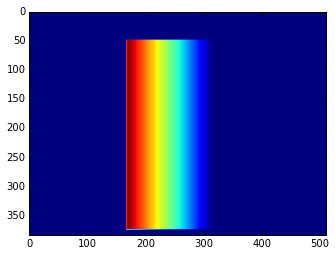

In [98]:
from pylab import *
%matplotlib inline
import cv2
dtest = np.array(([1,2,3],[4,5,6],[7,8,9]), dtype='float')

out = cv2.resize(X[3], (512,384))
imshow(out)

In [ ]:
path, dirs, files = os.walk("../caltech_peds/caltech_small/images/").next()
print len(files)
